In [1]:
%matplotlib inline
import sys
sys.path.append('../')
from Modules.Class_Basics import *
from Modules.Basics import *
import pandas as pd
import numpy as np

Using TensorFlow backend.


## function definitions

In [10]:
max_bkg_norm = 50.

def max_bkg(s, syst_factr):
    return np.power(s, .65)*max_bkg_norm/np.power(syst_factr, 0.65)

def l_asimov(s, b, syst_factr=0.5):
    spb = s+b
    b2 = b*b
    syst = syst_factr * b
    syst2 = syst*syst
    bpsyst2 = b+syst2

    l_val = 0.5/(
        spb * np.log(spb*bpsyst2/(b2+spb*syst2+1e-7)+1e-7)
        -b2/(syst2+1e-7) * np.log(1+syst2*s/(b*bpsyst2+1e-7))
    )

    return l_val #+ bovers*100

def hybrid(s, b, syst_factr=0.5):
    s+=1e-7
    b+=1e-7

    b_max  = max_bkg(s, syst_factr)
    ok = (b < b_max)
    out = ok * l_asimov(s, b, syst_factr)

    l_b_max = l_asimov(s, b_max, syst_factr)
    l_b_max0p95 = l_asimov(s, b_max*0.95, syst_factr)
    l_b_max1p05 = l_asimov(s, b_max*1.05, syst_factr)
    
    slope = (l_b_max1p05-l_b_max0p95) / (b_max*0.1) 
    offset = l_b_max - slope*b_max
    
    out += np.abs(1-ok) * (slope * b + offset)

    # stabelize low bound
    s_min = 0.2
    at_low_bound = s < s_min
    norm = l_asimov(s_min, b, syst_factr) / (b/s_min/s_min)
    out = np.abs(1-at_low_bound)*out
    out += at_low_bound*b/s/s*norm
    
    return out

def signifiLoss(s, b):
    return (b)/(s+1e-7)

In [11]:
# try some values by hand

s = 1e-4
b = 1e-1
print max_bkg(s, 0.5)
print l_asimov(s, b)
print hybrid(s, b)

0.1970786149885032
-547681.9436280145
15994965.429229902


## Plot against b (l_asimov and hybrid)

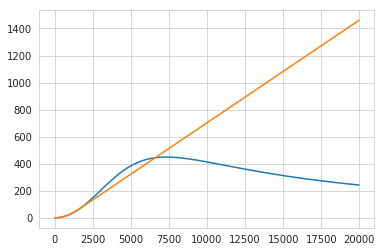

In [12]:
b_max = 20000
s_max = 100


x_b = np.arange(0., b_max, b_max/1000.)

y_b = l_asimov(s_max, x_b, 0.5)
plt.plot(x_b,y_b)
y_b = hybrid(s_max, x_b, 0.5)
plt.plot(x_b,y_b)

plt.show()

In [13]:
# conclusion:

# by manually testing where the maximum in b is for a fixed s, these tables are derived (with safety margin):

# syst_factr = 0.5: 
# s_min | b_max
# 1     | 200
# 10    | 1000
# 100   | 4000
# 1000  | 20000
# 10000 | 100000

# syst_factr = 0.3: 
# s_min | b_max
# 1     | 300
# 10    | 1500
# 100   | 7000
# 1000  | 30000
# 10000 | 125000

# syst_factr = 0.1: 
# s_min | b_max
# 1     | 600
# 10    | 3000
# 100   | 15000
# 1000  | 60000
# 10000 | 300000

## Plot hybrid against s

The yellow curve shows a simple power law function, f(x) = const / x

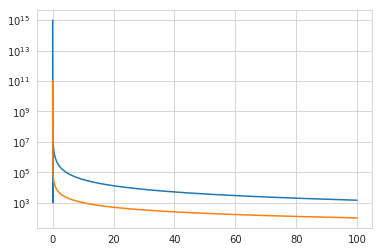

In [14]:
x_s = np.arange(0., s_max, s_max/1000.)
y_s = hybrid(x_s, b_max, 0.5)
plt.semilogy(x_s,y_s)
plt.semilogy(x_s,10000./x_s)
plt.show()

## 2D plot of l_asimov and hybrid (manual log scale applied)

/nfs/dust/cms/user/tholenhe/installs/anaconda2/envs/hepML3/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in divide
  from ipykernel import kernelapp as app
/nfs/dust/cms/user/tholenhe/installs/anaconda2/envs/hepML3/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """


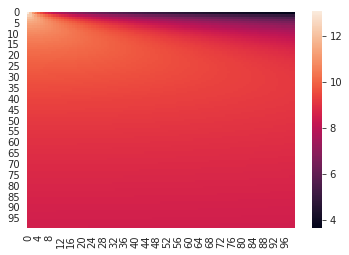

In [15]:
s = np.arange(0., 100.)*.01
b = np.arange(0., 100.)*10

S,B = np.meshgrid(s,b)
sns.heatmap(np.log(l_asimov(S,B)))

/nfs/dust/cms/user/tholenhe/installs/anaconda2/envs/hepML3/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


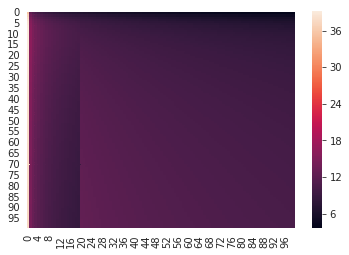

In [16]:
sns.heatmap(np.log(hybrid(S,B)))